LSTM model to predict (filtered) shear stress

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import time
from numpy.random import seed
seed(1)

import tensorflow as tf
tf.random.set_seed(1)


In [ ]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		samps = np.arange(i,end_ix,10)
		x1, y1 = data[samps, :-1], data[samps[-1], -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})    # TTF and TSF not used
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'A_filt':data['A_filt'].ravel(), 'V_filt':data['V_filt'].ravel(),
                    'T_pc':data['T_pc'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(), 'T_der':data['T_der'].ravel(), 'Vel_der':data['Vel_der'].ravel()})

df = a_t.merge(m_t, on='Time')

print("Input data:", df.shape)


Input data: (132399, 8)


In [ ]:
# Preprocessing

df = df.drop(['Time','T_der', 'Vel_der', 'T_pc', 'Vel_pc'], axis=1)   # Drop irrelevant features

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (132100, 30, 2)
Target shape, Y =  (132100,)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95112, 30, 2)
Validation: (10568, 30, 2)
Testing: (26420, 30, 2)


Epoch 1/10
2973/2973 [==============================] - 95s 32ms/step - loss: 1.5440 - val_loss: 0.0125
Epoch 2/10
2973/2973 [==============================] - 92s 31ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 3/10
2973/2973 [==============================] - 92s 31ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/10
2973/2973 [==============================] - 93s 31ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/10
2973/2973 [==============================] - 95s 32ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/10
2973/2973 [==============================] - 92s 31ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/10
2973/2973 [==============================] - 91s 31ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 8/10
2973/2973 [==============================] - 92s 31ms/step - loss: 8.8714e-04 - val_loss: 0.0011
Epoch 9/10
2973/2973 [==============================] - 92s 31ms/step - loss: 7.3678e-04 - val_loss: 8.6360e-04
Epoch 10/10
2973/2973 [=============================

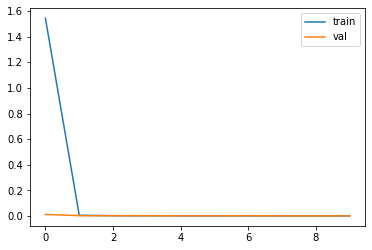

---Training time: 929.50419235 seconds ---


In [ ]:
# Build the model

model = Sequential()
model.add(LSTM(128, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
#model.add(Flatten())
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67072     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 75,393
Trainable params: 75,393
Non-trainable params: 0
_________________________________________________________________
None


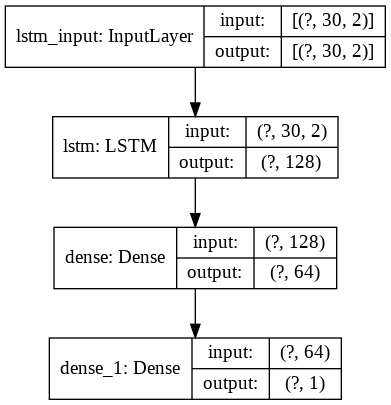

In [ ]:
print(model.summary())
plot_model(model, show_shapes=True)
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM_ss.h5')

In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()

test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

R2 scores: Train - 0.96733, Validation - 0.96824, Test - 0.93090
RMSE scores: Train - 0.02323, Validation - 0.02625, Test - 0.03800

---Time for Test data prediction: 6.08094525 seconds ---


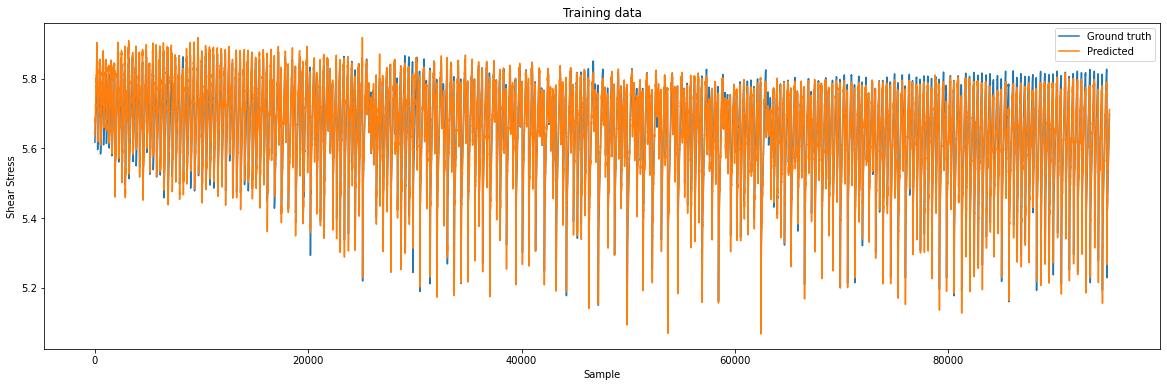

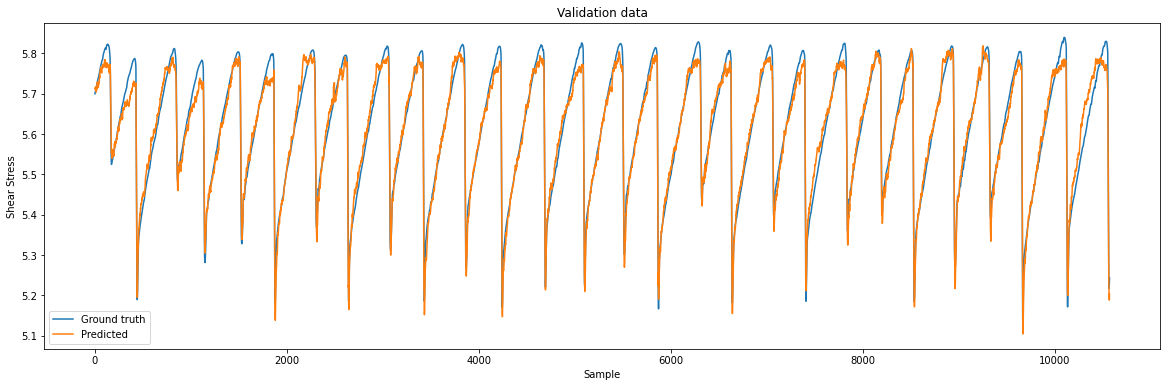

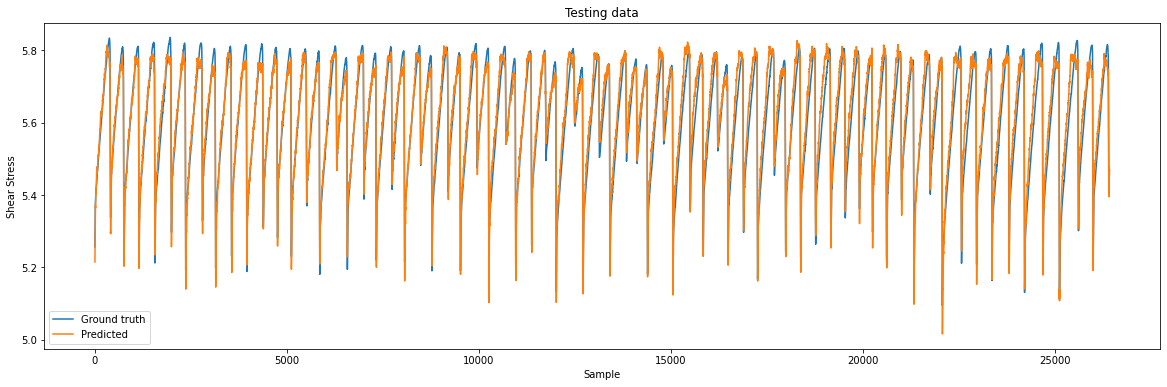

In [ ]:
# Results plot

def results_plot(fig_no, gt, pred, title):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Sample')
  plt.ylabel('Shear Stress')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train, y_predTrain, 'Training data')
results_plot(2, Y_val, y_predVal, 'Validation data')
results_plot(3, y_test, y_predTest, 'Testing data')


Text(0.5, 1.0, '5000 Samples, Testing Data')

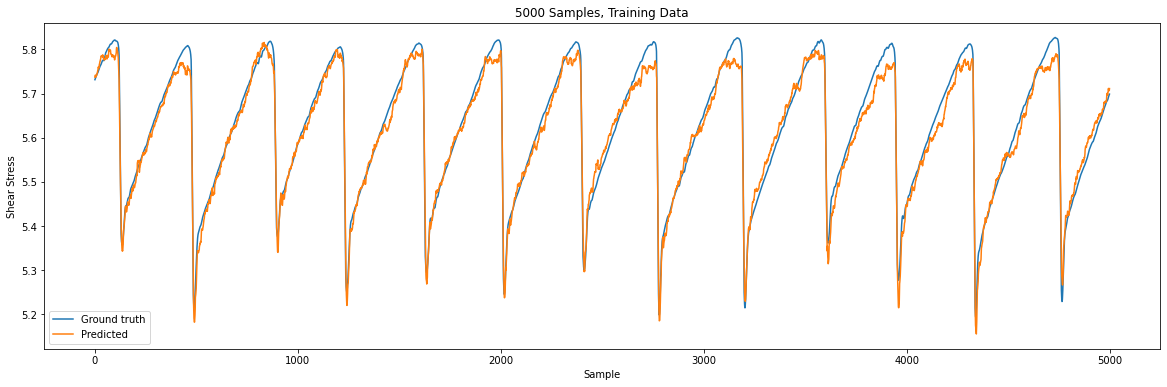

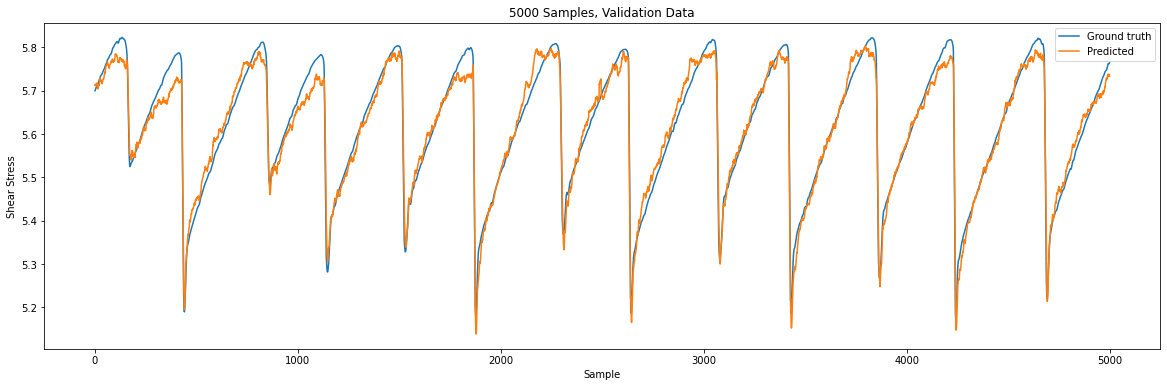

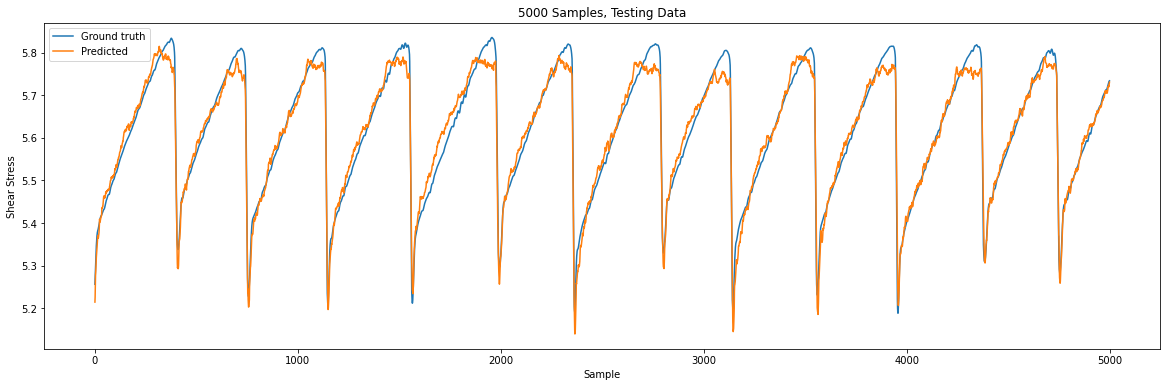

In [ ]:
# Detailed view of the plots

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-5000:])
plt.plot(y_predTrain[-5000:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:5000])
plt.plot(y_predVal[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:5000])
plt.plot(y_predTest[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Testing Data')


Text(0.5, 1.0, 'Shear Stress')

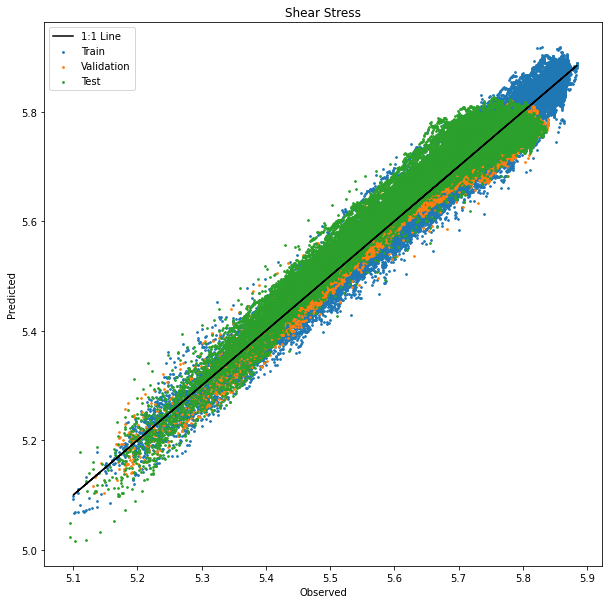

In [ ]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train, Y_train, 'black')
plt.scatter(Y_train, y_predTrain, s=3)
plt.scatter(Y_val, y_predVal, s=3)
plt.scatter(y_test, y_predTest, s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('Shear Stress')
